# Análisis Descriptivo - ENAHO 2020 (Salud)

## Objetivo general

Identificar los factores sociodemográficos y de acceso a servicios de salud que se asocian con la presencia de enfermedades crónicas en la población de Lima, mediante un modelo de regresión logística que permita cuantificar la influencia de cada variable.

## Objetivos Específicos:

1. **Analizar** las correlaciones entre las variables independientes seleccionadas (tipo de seguro, sexo, nivel educativo, estado civil, parentesco y ubicación del centro de salud) y la presencia de enfermedades crónicas, identificando las asociaciones más significativas.
2. **Construir** un modelo de regresión logística que permita estimar la probabilidad de padecer una enfermedad crónica en función de las características sociodemográficas y de acceso a salud del individuo.
3. **Evaluar** e interpretar los coeficientes del modelo para determinar qué factores tienen mayor influencia en la probabilidad de padecer enfermedades crónicas, generando recomendaciones basadas en los hallazgos.

## 1. Carga y Preparación de Datos
En esta sección cargaremos el dataset y el diccionario de datos. Nos enfocaremos en las variables resaltadas en el diccionario (variables 'coloreadas') para realizar una exploración inicial.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

# Configuración de gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [3]:
# Cargar datos
file_name = 'data.xlsx'
sheet_data = 'Enaho01-2020-400'
sheet_dic = 'Diccionario Enaho 400'

try:
    print("Cargando dataset...")
    df_data = pd.read_excel(file_name, sheet_name=0) # Asumimos hoja 0 si el nombre falla
    
    print("Cargando diccionario...")
    df_dic = pd.read_excel(file_name, sheet_name=sheet_dic)
    
    print(f"Dataset cargado: {df_data.shape[0]} filas, {df_data.shape[1]} columnas.")
except Exception as e:
    print(f"Error al cargar los archivos: {e}")

Cargando dataset...
Cargando diccionario...
Dataset cargado: 15545 filas, 123 columnas.


## 2. Identificación de Variables de Interés
Utilizaremos una función para identificar automáticamente las variables que están marcadas con color en el archivo Excel `data.xlsx` (Hoja: `Diccionario Enaho 400`).

In [4]:
def get_colored_variables(file_path, sheet_name):
    """
    Lee una hoja de Excel e identifica las celdas que tienen algún color de fondo.
    Retorna una lista de los valores de las celdas de la columna 'VARIABLE' asociadas a esas filas.
    """
    import openpyxl
    
    colored_vars = set()
    try:
        wb = openpyxl.load_workbook(file_path, data_only=True)
        if sheet_name not in wb.sheetnames:
            print(f"Hoja '{sheet_name}' no encontrada.")
            return []

        sheet = wb[sheet_name]
        
        variable_col_idx = None
        header_row = 1
        
        for cell in sheet[header_row]:
            if cell.value and "VARIABLE" in str(cell.value).upper():
                variable_col_idx = cell.column
                break
        
        if not variable_col_idx:
            print("No se encontró la columna 'VARIABLE'. Asumiendo columna B (índice 2).")
            variable_col_idx = 2

        print(f"Escaneando celdas coloreadas en '{sheet_name}'...")
        
        for row in sheet.iter_rows(min_row=2):
            for cell in row:
                is_colored = False
                if cell.fill and cell.fill.start_color:
                    color = cell.fill.start_color
                    
                    # Verificación RGB (Cubre A5A5A5)
                    if color.type == 'rgb':
                        # Ignoramos transparente/blanco: 00000000, FFFFFFFF
                        if color.rgb and color.rgb not in ['00000000', 'FFFFFFFF']:
                           is_colored = True
                    
                    # Verificación Indexed
                    elif color.type == 'indexed':
                        if color.index != 64:
                            is_colored = True
                            
                    # Verificación Theme (opcional, por si acaso)
                    elif color.type == 'theme':
                        is_colored = True

                if is_colored:
                    var_cell = sheet.cell(row=cell.row, column=variable_col_idx)
                    if var_cell.value:
                        colored_vars.add(str(var_cell.value).strip())

    except Exception as e:
        print(f"Error procesando Excel: {e}")
        return []

    return list(colored_vars)

# Ejecutamos la función
variables_coloreadas = get_colored_variables(file_name, sheet_dic)
print(f"Variables coloreadas detectadas: {len(variables_coloreadas)}")
print(variables_coloreadas)

# Filtramos solo las que existen en el dataset
vars_existentes = [v for v in variables_coloreadas if v in df_data.columns]
print(f"Variables encontradas en el dataset: {len(vars_existentes)} de {len(variables_coloreadas)}")

Escaneando celdas coloreadas en 'Diccionario Enaho 400'...
Variables coloreadas detectadas: 42
['P4192', 'P400A3', 'I41607', 'DPTO', 'I41605', 'TICUEST01A', 'P420A', 'I41609', 'I41613', 'I41612', 'TIPOENTREVISTA', 'P4196', 'P208B', 'P4197', 'P209', 'I41602', 'P4194', 'P301A', 'I41601', 'DISTRITO', 'PROV', 'I41608', 'P4191', 'I41614', 'P4195', 'I41610', 'I41606', 'AREA', 'TIPOCUESTIONARIO', 'I41611', 'P4198', 'I41604', 'I41615', 'CIUDAD', 'NIVEL', 'I41616', 'P4193', 'P203', 'P208A', 'P401', 'I41603', 'P207']
Variables encontradas en el dataset: 42 de 42


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1. Exploración de las 42 variables
Trabajaremos exclusivamente con las 42 variables identificadas (coloreadas). A continuación, creamos un subconjunto de datos y generamos un resumen de sus tipos, descripciones y estadísticas básicas para entender mejor la información disponible.

In [5]:
# Creación del Dataframe Reducido (Solo las 42 variables)
df_eda = df_data[vars_existentes].copy()
print(f"Nuevo Dataframe 'df_eda' creado con dimensiones: {df_eda.shape}")

# Limpieza de nombres de columnas del diccionario (quitar espacios)
if 'df_dic' in locals():
    df_dic.columns = df_dic.columns.str.strip()
    # Eliminar 'TIPO DE VARIABLE' si existe
    if 'TIPO DE VARIABLE' in df_dic.columns:
        df_dic = df_dic.drop(columns=['TIPO DE VARIABLE'])

# Generar Tabla Resumen con Descripciones
summary_data = []

for var in vars_existentes:
    # Buscar información en el diccionario
    info = df_dic[df_dic['VARIABLE'] == var]
    
    if not info.empty:
        desc = info['DESCRIPCIÓN'].values[0]
    else:
        desc = 'Descripción no encontrada'
        
    # Estadísticas básicas del dato real
    col_data = df_eda[var]
    datos_faltantes = col_data.isnull().sum()
    valores_unicos = col_data.nunique()
    tipo_pandas = col_data.dtype
    
    summary_data.append({
        'Variable': var,
        'Descripción': desc,
        'Tipo (Pandas)': str(tipo_pandas),
        'Nulos': datos_faltantes,
        'Unicos': valores_unicos
    })

df_summary = pd.DataFrame(summary_data)

# Separar en Categoricás (Object) y Numéricas (Float/Int)
df_cat = df_summary[df_summary['Tipo (Pandas)'].str.contains('object')].sort_values(by='Nulos', ascending=False)
df_num = df_summary[~df_summary['Tipo (Pandas)'].str.contains('object')].sort_values(by='Nulos', ascending=False)

from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

print("### Variables Categoricas (Object)")
display(df_cat)

print("\n### Variables Numericas (Float/Int)")
display(df_num)


Nuevo Dataframe 'df_eda' creado con dimensiones: (15545, 42)
### Variables Categoricas (Object)


,Variable,Descripción,Tipo (Pandas),Nulos,Unicos
6,P420A,"El centro o establecimiento de salud donde generalmente acude, ¿Esta ubicado:",object,7445,3
5,TICUEST01A,Origen de cuestionario,object,5366,2
34,NIVEL,Nivel del gasto en salud ( por hogar o persona ),object,5366,2
14,P209,¿Cuál es su estado civil o conyugal?,object,2446,6
17,P301A,¿Cuál es el último año o grado de estudios y nivel que aprobó? - Nivel,object,479,13
0,P4192,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro privado de salud?,object,13,2
30,P4198,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Otro?,object,13,2
39,P401,"¿Padece de alguna enfermedad o malestar crónico (Artritis, hipertensión, asma, reumatismo, diabetes, tuberculosis, VIH, colesterol, etc.)?",object,13,2
11,P4196,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro universitario?,object,13,2
13,P4197,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro escolar privado?,object,13,2



### Variables Numericas (Float/Int)


,Variable,Descripción,Tipo (Pandas),Nulos,Unicos
35,I41616,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Atenciones de parto",float64,15535,10
25,I41610,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Control de Salud de los Niños",float64,15534,11
32,I41615,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Controles por embarazo",float64,15524,20
4,I41605,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Otros Exámenes (Hemodiálisis, etc.)",float64,15508,36
7,I41609,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Vacunas",float64,15501,30
23,I41614,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Intervención Quirúrgica",float64,15482,50
8,I41613,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Hospitalización",float64,15475,54
31,I41604,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Rayos X, Tomografía, etc",float64,15465,64
40,I41603,"(Imputado, deflactado, anualizado) ¿Cuánto fue el monto total por la compra o servicio?: Análisis",float64,15418,82
12,P208B,¿Qúe edad tiene en años cumplidos? (En meses),float64,15411,12


### 3.2 Selección de Variable Objetivo (Y) - Análisis de Variables Binarias

Estudiaremos las variables categóricas binarias (2 valores únicos) para elegir nuestra variable objetivo (Y). Buscamos una variable cuya distribución de clases sea relativamente balanceada para asegurar un buen desempeño de los modelos predictivos.

| Concepto | Detalle |
|----------|---------|
| **Cálculo** | Distribución de frecuencias y proporción de cada clase. |
| **Por qué** | Verificar si la variable está balanceada. |
| **Qué buscar** | Evitar que una categoría represente >90% de los datos. Se busca idealmente una proporción entre 20% y 80% para ambas clases. |

In [6]:
# Filtrar variables categóricas con exactamente 2 valores únicos
binary_vars = df_cat[df_cat['Unicos'] == 2]['Variable'].tolist()
results = []

for var in binary_vars:
    # Obtener descripción
    desc = df_cat[df_cat['Variable'] == var]['Descripción'].values[0]
    
    # Calcular conteos excluyendo nulos
    counts = df_eda[var].value_counts(dropna=True)
    total = counts.sum()
    
    # Formatear la distribución string
    dist_parts = []
    max_prop = 0
    
    if total > 0:
        max_prop = counts.max() / total
        for cat, count in counts.items():
            prop = count / total
            dist_parts.append(f"{cat}: {prop:.1%} ({count})")
    else:
        dist_parts.append("Sin datos")
    
    # Evaluación del balance
    status = "Balanceado (OK)"
    if max_prop > 0.9:
        status = "Desbalanceado (>90%)"
    elif total == 0:
        status = "Sin datos"
        
    results.append({
        'Variable': var,
        'Descripción': desc,
        'Distribución (Clase: % (n))': " | ".join(dist_parts),
        'Estado': status
    })

df_binary_analysis = pd.DataFrame(results)

print(f"Se analizaron {len(binary_vars)} variables binarias.")
print("Mostrando resultados ordenados por Estado (los Desbalanceados primero para descartar):")
display(df_binary_analysis.sort_values(by='Estado', ascending=True))

Se analizaron 14 variables binarias.
Mostrando resultados ordenados por Estado (los Desbalanceados primero para descartar):


,Variable,Descripción,Distribución (Clase: % (n)),Estado
1,NIVEL,Nivel del gasto en salud ( por hogar o persona ),Gastos en salud a nivel personal: 80.8% (8228) | Gastos en salud consolidados a nivel de hogar: 19.2% (1951),Balanceado (OK)
4,P401,"¿Padece de alguna enfermedad o malestar crónico (Artritis, hipertensión, asma, reumatismo, diabetes, tuberculosis, VIH, colesterol, etc.)?",No: 57.1% (8871) | Si: 42.9% (6661),Balanceado (OK)
9,P4191,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿EsSalud?,No: 67.1% (10427) | EsSalud: 32.9% (5105),Balanceado (OK)
10,P4195,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro integral de salud (SIS)?,No: 63.0% (9783) | Seguro Integral de Salud (SIS): 37.0% (5749),Balanceado (OK)
12,TIPOENTREVISTA,Tipo de entrevista,presencial: 52.2% (8113) | telefónico: 47.8% (7430),Balanceado (OK)
13,P207,Sexo,Mujer: 50.8% (7900) | Hombre: 49.2% (7643),Balanceado (OK)
0,TICUEST01A,Origen de cuestionario,Cuestionario en Tablet: 100.0% (10178) | Cuestionario en hojas: 0.0% (1),Desbalanceado (>90%)
2,P4192,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro privado de salud?,No: 96.9% (15058) | Seguro Privado de Salud: 3.1% (474),Desbalanceado (>90%)
3,P4198,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Otro?,No: 99.4% (15440) | Otro: 0.6% (92),Desbalanceado (>90%)
5,P4196,El sistema de prestación de seguro de salud al cual Ud. está afiliado actualmente es: ¿Seguro universitario?,No: 99.6% (15470) | Seguro Universitario: 0.4% (62),Desbalanceado (>90%)


### 3.3 Generación de Nueva Variable: Tipo de Seguro

A partir de las variables `P4191` a `P4198`, crearemos una nueva variable numérica `TIPO_SEGURO` para clasificar el tipo de cobertura de cada persona.

**Codificación (cada variable tiene su propio código):**
*   **0**: Ninguno (sin seguro)
*   **1**: EsSalud (P4191)
*   **2**: Seguro Privado de Salud (P4192)
*   **3**: Entidad Prestadora de Salud - EPS (P4193)
*   **4**: Seguro FF.AA / Policiales (P4194)
*   **5**: Seguro Integral de Salud - SIS (P4195)
*   **6**: Seguro Universitario (P4196)
*   **7**: Seguro Escolar Privado (P4197)
*   **8**: Otro (P4198)


In [9]:
# Definimos la función de clasificación
def clasificar_seguro(row):
    # Función auxiliar para verificar si tiene el seguro (ignora 'No' y nulos)
    def has(col):
        val = row[col]
        # Verificamos que no sea nulo y que no sea la cadena 'No'
        if pd.isna(val) or val == 'No':
            return False
        return True

    # Cada variable tiene su propio código
    if has('P4191'):  # EsSalud
        return 1
    if has('P4192'):  # Seguro Privado de Salud
        return 2
    if has('P4193'):  # Entidad Prestadora de Salud (EPS)
        return 3
    if has('P4194'):  # Seguro FF.AA / Policiales
        return 4
    if has('P4195'):  # Seguro Integral de Salud (SIS)
        return 5
    if has('P4196'):  # Seguro Universitario
        return 6
    if has('P4197'):  # Seguro Escolar Privado
        return 7
    if has('P4198'):  # Otro
        return 8
        
    # Caso 0: Ninguno
    return 0

# Aplicamos la transformación
print("Generando nueva variable 'TIPO_SEGURO'...")
df_eda['TIPO_SEGURO'] = df_eda.apply(clasificar_seguro, axis=1)

# Visualizamos los resultados
print("Conteo por Tipo de Seguro:")
counts = df_eda['TIPO_SEGURO'].value_counts().sort_index()
print(counts)

# Etiquetas para cada tipo de seguro
labels = {
    0: 'Ninguno',
    1: 'EsSalud',
    2: 'Seguro Privado',
    3: 'EPS',
    4: 'FF.AA/Policiales',
    5: 'SIS',
    6: 'Universitario',
    7: 'Escolar Privado',
    8: 'Otro'
}
print("\nDistribución con etiquetas:")
print(counts.rename(index=labels))

Generando nueva variable 'TIPO_SEGURO'...
Conteo por Tipo de Seguro:
TIPO_SEGURO
0    4007
1    5105
2     207
3     118
4     266
5    5749
6      50
7       2
8      41
Name: count, dtype: int64

Distribución con etiquetas:
TIPO_SEGURO
Ninguno             4007
EsSalud             5105
Seguro Privado       207
EPS                  118
FF.AA/Policiales     266
SIS                 5749
Universitario         50
Escolar Privado        2
Otro                  41
Name: count, dtype: int64


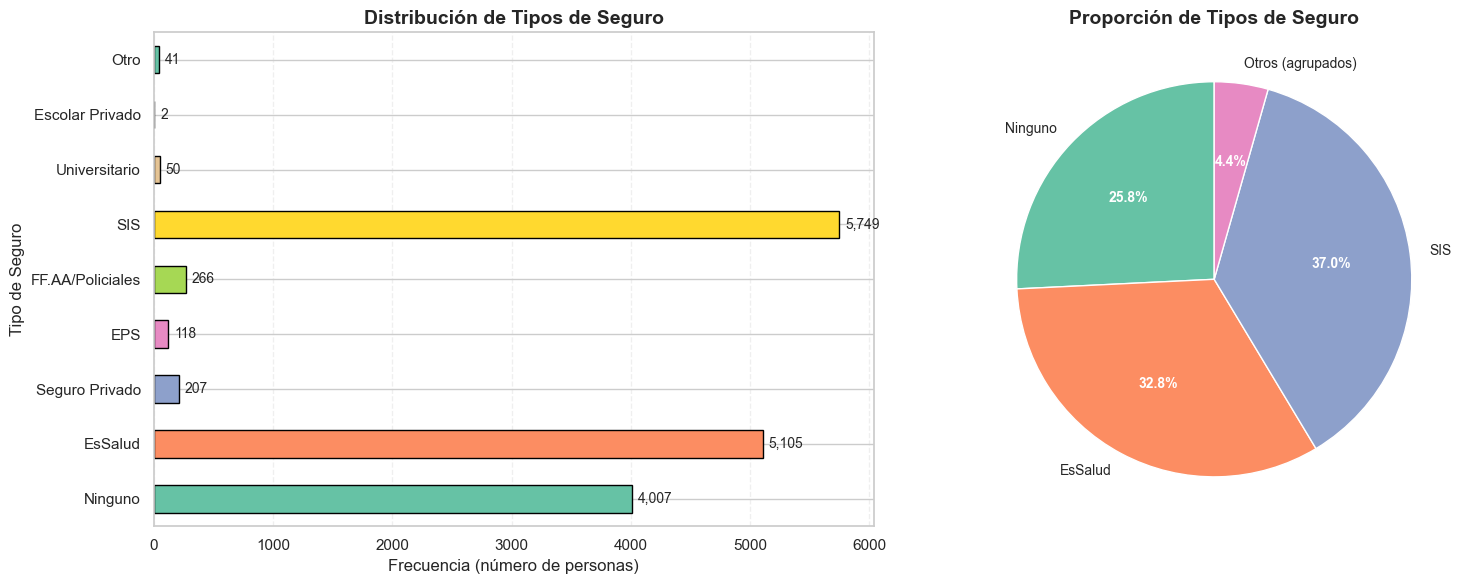


=== Estadísticas Descriptivas ===
Total de registros: 15,545

Tipo de seguro más común: SIS (5,749 personas, 37.0%)
Tipo de seguro menos común: Escolar Privado (2 personas, 0.0%)

Personas sin seguro: 4,007 (25.8%)
Personas con algún seguro: 11,538 (74.2%)


In [10]:
# Visualización de la variable TIPO_SEGURO
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar datos
labels_dict = {
    0: 'Ninguno',
    1: 'EsSalud',
    2: 'Seguro Privado',
    3: 'EPS',
    4: 'FF.AA/Policiales',
    5: 'SIS',
    6: 'Universitario',
    7: 'Escolar Privado',
    8: 'Otro'
}

counts = df_eda['TIPO_SEGURO'].value_counts().sort_index()
counts_labeled = counts.rename(index=labels_dict)

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Gráfico de Barras Horizontal
colors = sns.color_palette('Set2', len(counts_labeled))
counts_labeled.plot(kind='barh', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Distribución de Tipos de Seguro', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frecuencia (número de personas)', fontsize=12)
ax1.set_ylabel('Tipo de Seguro', fontsize=12)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for i, v in enumerate(counts_labeled.values):
    ax1.text(v + 50, i, f'{v:,}', va='center', fontsize=10)

# 2. Gráfico de Pastel
# Filtrar categorías muy pequeñas para mejor visualización
threshold = 0.02  # 2%
total = counts_labeled.sum()
counts_pie = counts_labeled.copy()
small_categories = counts_pie[counts_pie / total < threshold]

if len(small_categories) > 0:
    counts_pie = counts_pie[counts_pie / total >= threshold]
    counts_pie['Otros (agrupados)'] = small_categories.sum()

# Crear pastel
wedges, texts, autotexts = ax2.pie(
    counts_pie.values,
    labels=counts_pie.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set2', len(counts_pie)),
    textprops={'fontsize': 10}
)

# Mejorar legibilidad de porcentajes
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax2.set_title('Proporción de Tipos de Seguro', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print("\n=== Estadísticas Descriptivas ===")
print(f"Total de registros: {total:,}")
print(f"\nTipo de seguro más común: {counts_labeled.idxmax()} ({counts_labeled.max():,} personas, {counts_labeled.max()/total*100:.1f}%)")
print(f"Tipo de seguro menos común: {counts_labeled.idxmin()} ({counts_labeled.min():,} personas, {counts_labeled.min()/total*100:.1f}%)")
print(f"\nPersonas sin seguro: {counts_labeled.get('Ninguno', 0):,} ({counts_labeled.get('Ninguno', 0)/total*100:.1f}%)")
print(f"Personas con algún seguro: {total - counts_labeled.get('Ninguno', 0):,} ({(total - counts_labeled.get('Ninguno', 0))/total*100:.1f}%)")

In [11]:
# Crear DataFrame filtrado con variables seleccionadas
print("=== Creando DataFrame Filtrado ===")
print("\nVariables seleccionadas:")

# Lista de variables a incluir
selected_vars = [
    'TIPO_SEGURO',  # Variable generada
    'NIVEL',        # Nivel del gasto en salud
    'P401',         # Enfermedad crónica
    'P207',         # Sexo
    'P420A',        # Ubicación del centro de salud
    'P209',         # Estado civil
    'P301A',        # Nivel educativo
    'P203',         # Relación de parentesco
    'CIUDAD',       # Ciudad
    'PROV',         # Provincia
    'DISTRITO'      # Distrito
]

# Verificar que todas las variables existen en df_eda
missing_vars = [v for v in selected_vars if v not in df_eda.columns]
if missing_vars:
    print(f"\n⚠️  Advertencia: Variables no encontradas: {missing_vars}")
    selected_vars = [v for v in selected_vars if v in df_eda.columns]

# Crear el DataFrame filtrado
df_filtered = df_eda[selected_vars].copy()

print(f"\n✓ DataFrame creado con {df_filtered.shape[0]} filas y {df_filtered.shape[1]} columnas")
print(f"\nColumnas incluidas: {list(df_filtered.columns)}")

# Mostrar información general del DataFrame
print("\n" + "="*80)
print("RESUMEN DE VARIABLES SELECCIONADAS")
print("="*80)

# Crear tabla resumen
summary_list = []

for col in df_filtered.columns:
    dtype = df_filtered[col].dtype
    n_missing = df_filtered[col].isnull().sum()
    pct_missing = (n_missing / len(df_filtered)) * 100
    n_unique = df_filtered[col].nunique()
    
    # Obtener descripción del diccionario si existe
    if col != 'TIPO_SEGURO':
        desc_row = df_dic[df_dic['VARIABLE'] == col]
        if not desc_row.empty:
            description = desc_row['DESCRIPCIÓN'].values[0]
        else:
            description = 'N/A'
    else:
        description = 'Tipo de Seguro (Variable Generada)'
    
    summary_list.append({
        'Variable': col,
        'Descripción': description,
        'Tipo': str(dtype),
        'Nulos': n_missing,
        '% Nulos': f"{pct_missing:.2f}%",
        'Únicos': n_unique
    })

df_summary_filtered = pd.DataFrame(summary_list)

# Configurar display para mostrar todo
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 60)

from IPython.display import display
display(df_summary_filtered)

# Mostrar primeras filas del DataFrame filtrado
print("\n" + "="*80)
print("PRIMERAS 10 FILAS DEL DATAFRAME FILTRADO")
print("="*80)
display(df_filtered.head(10))

# Estadísticas adicionales
print("\n" + "="*80)
print("ESTADÍSTICAS ADICIONALES")
print("="*80)
print(f"Total de registros: {len(df_filtered):,}")
print(f"Total de variables: {len(df_filtered.columns)}")
print(f"\nRegistros completos (sin valores nulos): {df_filtered.dropna().shape[0]:,}")
print(f"Registros con al menos un valor nulo: {df_filtered.shape[0] - df_filtered.dropna().shape[0]:,}")

# Guardar para uso posterior
print("\n✓ DataFrame 'df_filtered' creado y listo para análisis")

=== Creando DataFrame Filtrado ===

Variables seleccionadas:

✓ DataFrame creado con 15545 filas y 11 columnas

Columnas incluidas: ['TIPO_SEGURO', 'NIVEL', 'P401', 'P207', 'P420A', 'P209', 'P301A', 'P203', 'CIUDAD', 'PROV', 'DISTRITO']

RESUMEN DE VARIABLES SELECCIONADAS


,Variable,Descripción,Tipo,Nulos,% Nulos,Únicos
0,TIPO_SEGURO,Tipo de Seguro (Variable Generada),int64,0,0.00%,9
1,NIVEL,Nivel del gasto en salud ( por hogar o persona ),object,5366,34.52%,2
2,P401,¿Padece de alguna enfermedad o malestar crónico (Artriti...,object,13,0.08%,2
3,P207,Sexo,object,2,0.01%,2
4,P420A,El centro o establecimiento de salud donde generalmente ...,object,7445,47.89%,3
5,P209,¿Cuál es su estado civil o conyugal?,object,2446,15.73%,6
6,P301A,¿Cuál es el último año o grado de estudios y nivel que a...,object,479,3.08%,13
7,P203,¿Cuál es la relación de parentesco con el jefe(a) del ho...,object,2,0.01%,10
8,CIUDAD,CIUDAD,object,2,0.01%,11
9,PROV,PROV,object,2,0.01%,10



PRIMERAS 10 FILAS DEL DATAFRAME FILTRADO


,TIPO_SEGURO,NIVEL,P401,P207,P420A,P209,P301A,P203,CIUDAD,PROV,DISTRITO
0,1,Gastos en salud a nivel personal,Si,Hombre,En otro distrito,Casado(a),Superior Universitaria Incompleta,Jefe/Jefa,LIMA METROPOLITANA,Lima,Carabayllo
1,1,Gastos en salud a nivel personal,No,Mujer,En otro distrito,Casado(a),Superior Universitaria Incompleta,Esposo(a)/compañero(a),LIMA METROPOLITANA,Lima,Carabayllo
2,1,Gastos en salud a nivel personal,Si,Mujer,No acude a establecimiento de salud,Soltero(a),Superior Universitaria Incompleta,Hijo(a)/Hijastro(a),LIMA METROPOLITANA,Lima,Carabayllo
3,1,Gastos en salud a nivel personal,Si,Mujer,En otro distrito,Soltero(a),Superior Universitaria Incompleta,Hijo(a)/Hijastro(a),LIMA METROPOLITANA,Lima,Carabayllo
4,0,Gastos en salud a nivel personal,No,Hombre,En otro distrito,Casado(a),Secundaria Completa,Jefe/Jefa,LIMA METROPOLITANA,Lima,Carabayllo
5,1,Gastos en salud a nivel personal,No,Mujer,En otro distrito,Casado(a),Secundaria Completa,Esposo(a)/compañero(a),LIMA METROPOLITANA,Lima,Carabayllo
6,5,Gastos en salud a nivel personal,No,Hombre,Aqui en este distrito,Viudo(a),Secundaria Completa,Padres/Suegros,LIMA METROPOLITANA,Lima,Carabayllo
7,5,Gastos en salud a nivel personal,No,Mujer,No acude a establecimiento de salud,Soltero(a),Secundaria Completa,Otros parientes,LIMA METROPOLITANA,Lima,Carabayllo
8,0,Gastos en salud a nivel personal,No,Hombre,En otro distrito,Soltero(a),Superior Universitaria Incompleta,Otros parientes,LIMA METROPOLITANA,Lima,Carabayllo
9,1,Gastos en salud a nivel personal,No,Mujer,En otro distrito,Conviviente,Secundaria Completa,Jefe/Jefa,LIMA METROPOLITANA,Lima,Carabayllo



ESTADÍSTICAS ADICIONALES
Total de registros: 15,545
Total de variables: 11

Registros completos (sin valores nulos): 6,879
Registros con al menos un valor nulo: 8,666

✓ DataFrame 'df_filtered' creado y listo para análisis


=== Visualización de Variables Geográficas ===


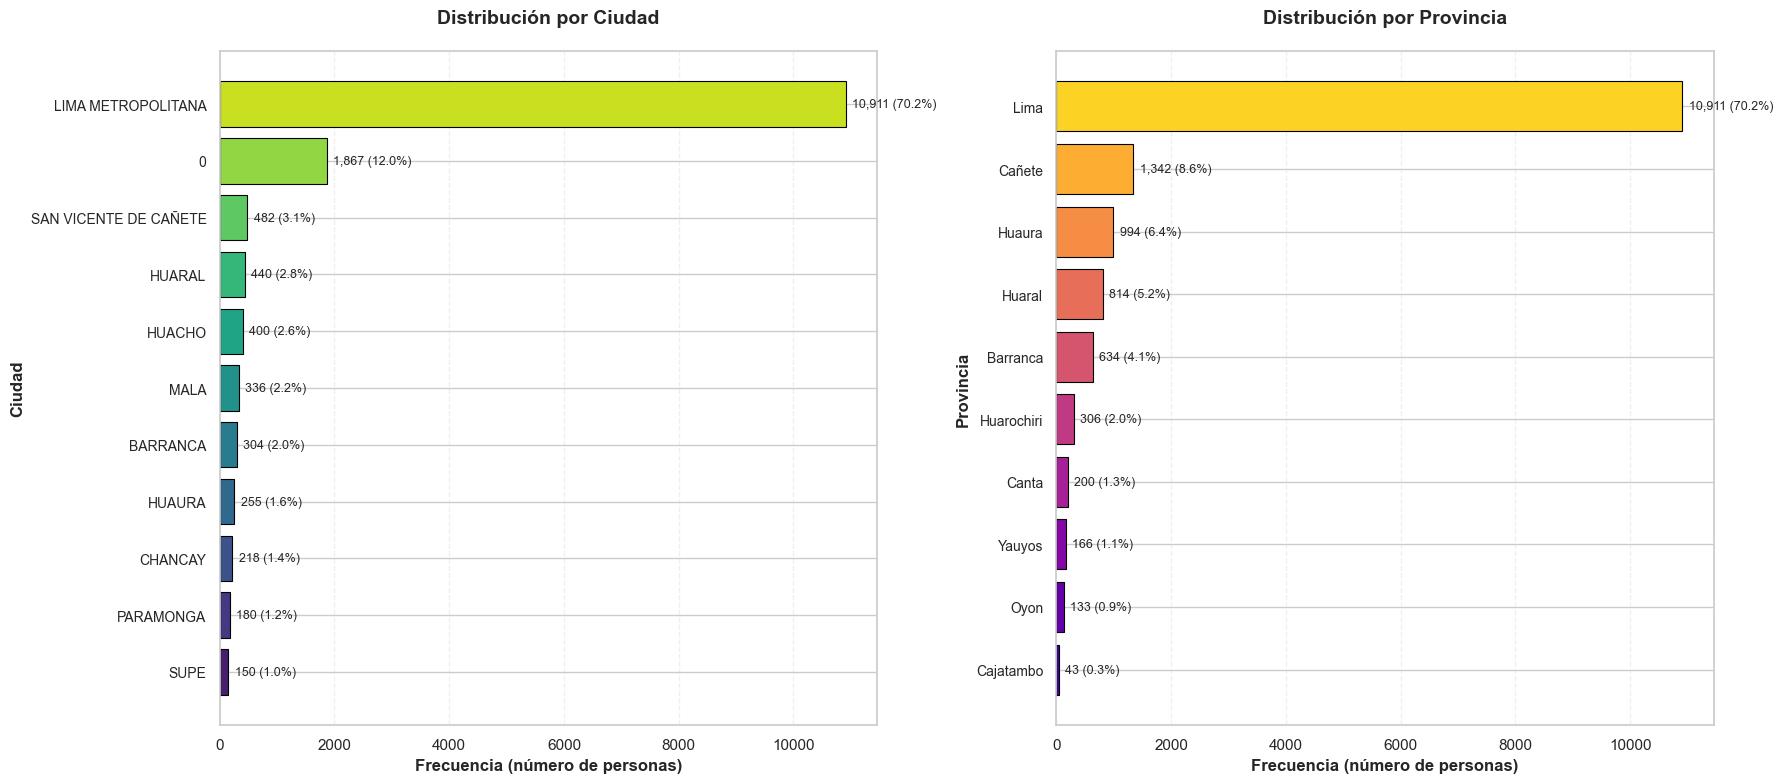


ESTADÍSTICAS DESCRIPTIVAS

📍 CIUDAD:
  • Total de ciudades únicas: 11
  • Ciudad más frecuente: LIMA METROPOLITANA (10,911 personas, 70.2%)
  • Ciudad menos frecuente: SUPE (150 personas, 1.0%)

🗺️  PROVINCIA:
  • Total de provincias únicas: 10
  • Provincia más frecuente: Lima (10,911 personas, 70.2%)
  • Provincia menos frecuente: Cajatambo (43 personas, 0.3%)

TABLA DETALLADA DE VALORES

--- CIUDAD ---


,Ciudad,Frecuencia,Porcentaje
10,LIMA METROPOLITANA,10911,70.20%
9,0,1867,12.01%
8,SAN VICENTE DE CAÑETE,482,3.10%
7,HUARAL,440,2.83%
6,HUACHO,400,2.57%
5,MALA,336,2.16%
4,BARRANCA,304,1.96%
3,HUAURA,255,1.64%
2,CHANCAY,218,1.40%
1,PARAMONGA,180,1.16%



--- PROVINCIA ---


,Provincia,Frecuencia,Porcentaje
9,Lima,10911,70.20%
8,Cañete,1342,8.63%
7,Huaura,994,6.40%
6,Huaral,814,5.24%
5,Barranca,634,4.08%
4,Huarochiri,306,1.97%
3,Canta,200,1.29%
2,Yauyos,166,1.07%
1,Oyon,133,0.86%
0,Cajatambo,43,0.28%


In [12]:
# Visualización de variables geográficas: CIUDAD y PROV
import matplotlib.pyplot as plt
import seaborn as sns

print("=== Visualización de Variables Geográficas ===")

# Preparar datos
ciudad_counts = df_filtered['CIUDAD'].value_counts().sort_values(ascending=True)
prov_counts = df_filtered['PROV'].value_counts().sort_values(ascending=True)

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Paleta de colores
colors_ciudad = sns.color_palette('viridis', len(ciudad_counts))
colors_prov = sns.color_palette('plasma', len(prov_counts))

# 1. Gráfico de CIUDAD
bars1 = ax1.barh(range(len(ciudad_counts)), ciudad_counts.values, 
                  color=colors_ciudad, edgecolor='black', linewidth=0.8)
ax1.set_yticks(range(len(ciudad_counts)))
ax1.set_yticklabels(ciudad_counts.index, fontsize=10)
ax1.set_xlabel('Frecuencia (número de personas)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Ciudad', fontsize=12, fontweight='bold')
ax1.set_title('Distribución por Ciudad', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for i, (v, label) in enumerate(zip(ciudad_counts.values, ciudad_counts.index)):
    percentage = (v / ciudad_counts.sum()) * 100
    ax1.text(v + max(ciudad_counts.values) * 0.01, i, 
             f'{v:,} ({percentage:.1f}%)', 
             va='center', fontsize=9)

# 2. Gráfico de PROVINCIA
bars2 = ax2.barh(range(len(prov_counts)), prov_counts.values, 
                  color=colors_prov, edgecolor='black', linewidth=0.8)
ax2.set_yticks(range(len(prov_counts)))
ax2.set_yticklabels(prov_counts.index, fontsize=10)
ax2.set_xlabel('Frecuencia (número de personas)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Provincia', fontsize=12, fontweight='bold')
ax2.set_title('Distribución por Provincia', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Agregar valores en las barras
for i, (v, label) in enumerate(zip(prov_counts.values, prov_counts.index)):
    percentage = (v / prov_counts.sum()) * 100
    ax2.text(v + max(prov_counts.values) * 0.01, i, 
             f'{v:,} ({percentage:.1f}%)', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("\n" + "="*80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*80)

print("\n📍 CIUDAD:")
print(f"  • Total de ciudades únicas: {len(ciudad_counts)}")
print(f"  • Ciudad más frecuente: {ciudad_counts.index[-1]} ({ciudad_counts.iloc[-1]:,} personas, {ciudad_counts.iloc[-1]/ciudad_counts.sum()*100:.1f}%)")
print(f"  • Ciudad menos frecuente: {ciudad_counts.index[0]} ({ciudad_counts.iloc[0]:,} personas, {ciudad_counts.iloc[0]/ciudad_counts.sum()*100:.1f}%)")

print("\n🗺️  PROVINCIA:")
print(f"  • Total de provincias únicas: {len(prov_counts)}")
print(f"  • Provincia más frecuente: {prov_counts.index[-1]} ({prov_counts.iloc[-1]:,} personas, {prov_counts.iloc[-1]/prov_counts.sum()*100:.1f}%)")
print(f"  • Provincia menos frecuente: {prov_counts.index[0]} ({prov_counts.iloc[0]:,} personas, {prov_counts.iloc[0]/prov_counts.sum()*100:.1f}%)")

# Tabla detallada de valores
print("\n" + "="*80)
print("TABLA DETALLADA DE VALORES")
print("="*80)

print("\n--- CIUDAD ---")
ciudad_df = pd.DataFrame({
    'Ciudad': ciudad_counts.index,
    'Frecuencia': ciudad_counts.values,
    'Porcentaje': [f"{(v/ciudad_counts.sum())*100:.2f}%" for v in ciudad_counts.values]
}).sort_values('Frecuencia', ascending=False)
display(ciudad_df)

print("\n--- PROVINCIA ---")
prov_df = pd.DataFrame({
    'Provincia': prov_counts.index,
    'Frecuencia': prov_counts.values,
    'Porcentaje': [f"{(v/prov_counts.sum())*100:.2f}%" for v in prov_counts.values]
}).sort_values('Frecuencia', ascending=False)
display(prov_df)

## 4. Selección de Variables

### 4.1 Justificación de Eliminación de Variables

Tras el análisis exploratorio realizado en las secciones anteriores, hemos decidido trabajar con un conjunto reducido de variables que cumplen con los siguientes criterios:

1. **Calidad de datos**: Variables con bajo porcentaje de valores nulos
2. **Relevancia temática**: Variables relacionadas con salud, demografía y contexto socioeconómico
3. **Variabilidad**: Variables con distribución balanceada que permitan análisis significativos
4. **No redundancia**: Evitar variables que midan el mismo concepto

**Variables numéricas descartadas:**
La gran mayoría de las variables numéricas relacionadas con gastos en salud (I41601-I41616) fueron descartadas debido a la excesiva cantidad de valores nulos (>80%). Mantenerlas requeriría técnicas de imputación agresivas que podrían introducir sesgos significativos.

**Variables geográficas descartadas:**
Las variables CIUDAD, PROV y DISTRITO fueron excluidas del modelo final para mantener la simplicidad y generalización del análisis, aunque fueron exploradas en la fase de EDA.

---

### 4.2 Variables Seleccionadas para el Análisis

#### **Variable Dependiente (Y):**

**Y: P401** - *¿Padece de alguna enfermedad o malestar crónico?*
- **Tipo**: Categórica binaria (Sí/No)
- **Justificación**: Variable objetivo ideal por su distribución balanceada (57.1% No, 42.9% Sí) y alta relevancia para políticas públicas de salud. Identificar los determinantes de enfermedades crónicas permite focalizar mejor los recursos y programas preventivos.
- **Valores nulos**: 13 (0.08%)

---

#### **Variables Independientes (X):**

**X1: TIPO_SEGURO** - *Tipo de Seguro de Salud (Variable Generada)*
- **Tipo**: Categórica ordinal (0-8)
- **Valores**: 0=Ninguno, 1=EsSalud, 2=Privado, 3=EPS, 4=FF.AA/Policiales, 5=SIS, 6=Universitario, 7=Escolar, 8=Otro
- **Justificación**: Variable clave que sintetiza el acceso a servicios de salud. El tipo de seguro está directamente relacionado con la prevención y tratamiento de enfermedades crónicas.
- **Valores nulos**: 0 (0%)

**X2: NIVEL** - *Nivel del gasto en salud (por hogar o persona)*
- **Tipo**: Categórica binaria
- **Valores**: Personal (80.8%) / Hogar (19.2%)
- **Justificación**: Indica si el gasto en salud se registra a nivel individual o familiar, lo cual puede estar relacionado con la presencia de enfermedades crónicas que requieren seguimiento personalizado.
- **Valores nulos**: 5,366 (34.5%)

**X3: P207** - *Sexo*
- **Tipo**: Categórica binaria
- **Valores**: Mujer (50.8%) / Hombre (49.2%)
- **Justificación**: Variable demográfica fundamental. Existen diferencias significativas en la prevalencia de enfermedades crónicas según el sexo.
- **Valores nulos**: 2 (0.01%)

**X4: P420A** - *Ubicación del centro de salud donde generalmente acude*
- **Tipo**: Categórica
- **Valores**: 3 categorías de ubicación
- **Justificación**: La accesibilidad a centros de salud puede influir en el diagnóstico y control de enfermedades crónicas.
- **Valores nulos**: 7,445 (47.9%)

**X5: P209** - *Estado civil o conyugal*
- **Tipo**: Categórica
- **Valores**: 6 categorías (Conviviente, Casado, Soltero, Viudo, Divorciado, Separado)
- **Justificación**: El estado civil puede estar asociado con hábitos de vida, redes de apoyo y acceso a cuidados que influyen en la salud crónica.
- **Valores nulos**: 2,446 (15.7%)

**X6: P301A** - *Nivel educativo (último año o grado aprobado)*
- **Tipo**: Categórica ordinal
- **Valores**: 13 niveles educativos
- **Justificación**: El nivel educativo está fuertemente correlacionado con conocimientos sobre salud, prevención y acceso a servicios médicos.
- **Valores nulos**: 479 (3.1%)

**X7: P203** - *Relación de parentesco con el jefe(a) del hogar*
- **Tipo**: Categórica
- **Valores**: 10 categorías
- **Justificación**: La posición en el hogar puede reflejar responsabilidades, estrés y acceso a recursos que impactan en la salud.
- **Valores nulos**: 2 (0.01%)

---

### 4.3 Resumen de Variables Seleccionadas

| Variable | Código | Tipo | Descripción Breve |
|----------|--------|------|-------------------|
| **Y** | P401 | Binaria | Enfermedad crónica (Sí/No) |
| **X1** | TIPO_SEGURO | Ordinal (0-8) | Tipo de seguro de salud |
| **X2** | NIVEL | Binaria | Nivel de gasto en salud |
| **X3** | P207 | Binaria | Sexo (Mujer/Hombre) |
| **X4** | P420A | Categórica | Ubicación centro de salud |
| **X5** | P209 | Categórica | Estado civil |
| **X6** | P301A | Ordinal | Nivel educativo |
| **X7** | P203 | Categórica | Parentesco con jefe de hogar |

**Total**: 1 variable dependiente + 7 variables independientes = **8 variables para el análisis**


## 5. Análisis de Correlación
A continuación, realizaremos el análisis de correlación entre las variables numéricas seleccionadas.

In [ ]:
# Ejemplo de código para correlación (se activará una vez seleccionadas las variables)
# cols_corr = ['P208A', 'I41601', ...]
# sns.heatmap(df_data[cols_corr].corr(), annot=True, cmap='coolwarm')

## 7. Análisis de Regresión
*(Espacio para Regresión Lineal o Logística)*

## 4. Preprocesamiento de Datos para Modelado

En esta etapa prepararemos los datos para los algoritmos de machine learning. Esto incluye:
1. Tratamiento final de valores nulos.
2. Codificación de la variable objetivo (Enfermedad Crónica).
3. Codificación de variables categóricas (One-Hot Encoding).

In [13]:
# Crear copia para modelado
df_model = df_filtered.copy()

# 1. Variable Objetivo: P401 (Enfermedad Crónica)
# Eliminar nulos en target (son pocos)
df_model = df_model.dropna(subset=['P401'])
# Codificar: Si=1, No=0
df_model['TARGET'] = df_model['P401'].apply(lambda x: 1 if x == 'Si' else 0)

# 2. Selección de Variables Predictoras (según objetivos)
# TIPO_SEGURO ya fue creada. Otras variables: P207(Sexo), P301A(Estudios), P209(Civil), P203(Parentesco), P420A(Lugar Salud)
predictoras = ['TIPO_SEGURO', 'P207', 'P301A', 'P209', 'P203', 'P420A']

# Validar que existan en el dataframe
predictoras = [c for c in predictoras if c in df_model.columns]

# 3. Tratamiento de Nulos en Predictoras
# Para variables categóricas con nulos, imputamos con 'No especificado' para conservar la data.
for col in predictoras:
    if df_model[col].dtype == 'object':
        df_model[col] = df_model[col].fillna('No especificado')
    else:
        df_model[col] = df_model[col].fillna(0)

print("Distribución del Target (1=Enfermedad Crónica):")
print(df_model['TARGET'].value_counts(normalize=True))
print(f"\nDimensiones del dataset para modelado: {df_model.shape}")

Distribución del Target (1=Enfermedad Crónica):
TARGET
0    0.571143
1    0.428857
Name: proportion, dtype: float64

Dimensiones del dataset para modelado: (15532, 12)


## 5. Análisis de Correlación (Asociación Categórica)

Dado que la mayoría de nuestras variables son categóricas, utilizaremos la **V de Cramer** para medir la fuerza de asociación entre las variables predictoras y el target (Enfermedad Crónica).

/var/folders/ry/zb_bj0bx0d39hp_mkrvscf7m0000gn/T/ipykernel_30006/558199082.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_asoc, x='V_Cramer', y='Variable', palette='viridis')


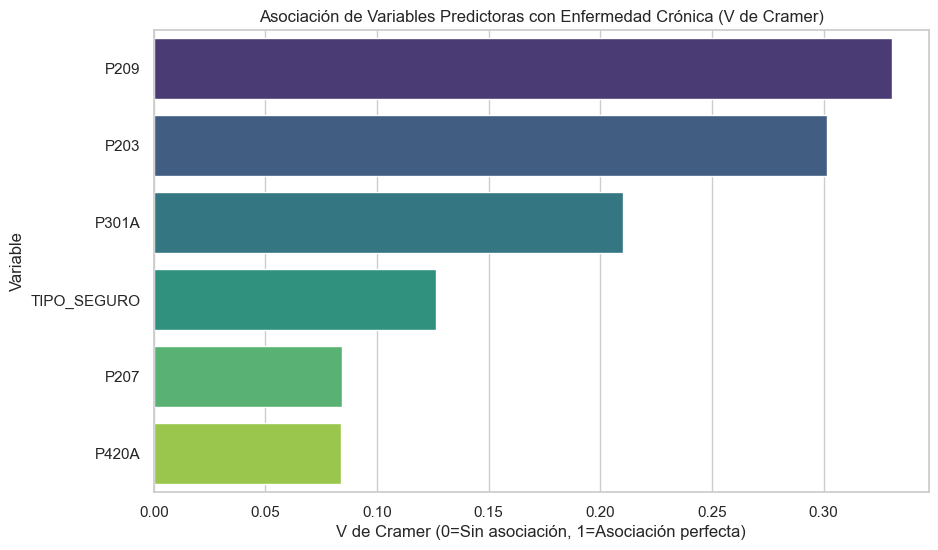

Tabla de Asociación:


,Variable,V_Cramer
3,P209,0.330491
4,P203,0.301327
2,P301A,0.210138
0,TIPO_SEGURO,0.126415
1,P207,0.084219
5,P420A,0.083633


In [14]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calcula la V de Cramer para dos series categóricas"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0:
        return 0
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calcular asociación con el Target
asociaciones = []
for col in predictoras:
    if col in df_model.columns:
        v = cramers_v(df_model[col], df_model['TARGET'])
        asociaciones.append({'Variable': col, 'V_Cramer': v})

df_asoc = pd.DataFrame(asociaciones).sort_values('V_Cramer', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(data=df_asoc, x='V_Cramer', y='Variable', palette='viridis')
plt.title('Asociación de Variables Predictoras con Enfermedad Crónica (V de Cramer)')
plt.xlabel('V de Cramer (0=Sin asociación, 1=Asociación perfecta)')
plt.show()

print("Tabla de Asociación:")
display(df_asoc)

## 6. Regresión Logística

Construiremos un modelo de regresión logística para estimar la probabilidad de padecer una enfermedad crónica en función de las variables seleccionadas. Utilizaremos validación cruzada simple (Train/Test Split).

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Preparar datos (One-Hot Encoding)
# Convertimos variables categóricas a dummies
X = pd.get_dummies(df_model[predictoras], drop_first=True)
y = df_model['TARGET']

# 2. Split Train/Test (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Set de Entrenamiento: {X_train.shape}")
print(f"Set de Prueba: {X_test.shape}")

# 3. Entrenar Modelo
# Usamos class_weight='balanced' porque el target suele estar desbalanceado en salud
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

print("\n✓ Modelo de Regresión Logística Entrenado.")

Set de Entrenamiento: (10872, 33)
Set de Prueba: (4660, 33)

✓ Modelo de Regresión Logística Entrenado.


/Users/sebastianchavarry01/Documents/data-scientist-specialization/descriptive-statistics/DMC_DS19_TRABAJO FINAL/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sebastianchavarry01/Documents/data-scientist-specialization/descriptive-statistics/DMC_DS19_TRABAJO FINAL/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sebastianchavarry01/Documents/data-scientist-specialization/descriptive-statistics/DMC_DS19_TRABAJO FINAL/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sebastianchavarry01/Documents/data-scientist-specialization/descriptive-statistics/DMC_DS19_TRABAJO FINAL/.venv/lib/python3.9/site-packages/sklea

## 7. Evaluación e Interpretación del Modelo

Evaluaremos el desempeño del modelo y analizaremos los coeficientes (Odds Ratios) para interpretar el impacto de cada variable.

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.72      0.67      0.70      2662
           1       0.60      0.65      0.62      1998

    accuracy                           0.66      4660
   macro avg       0.66      0.66      0.66      4660
weighted avg       0.67      0.66      0.67      4660

AUC-ROC Score: 0.7194


/Users/sebastianchavarry01/Documents/data-scientist-specialization/descriptive-statistics/DMC_DS19_TRABAJO FINAL/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sebastianchavarry01/Documents/data-scientist-specialization/descriptive-statistics/DMC_DS19_TRABAJO FINAL/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sebastianchavarry01/Documents/data-scientist-specialization/descriptive-statistics/DMC_DS19_TRABAJO FINAL/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sebastianchavarry01/Documents/data-scientist-specialization/descriptive-statistics/DMC_DS19_TRABAJO FINAL/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sebastianchavarry01/Docu

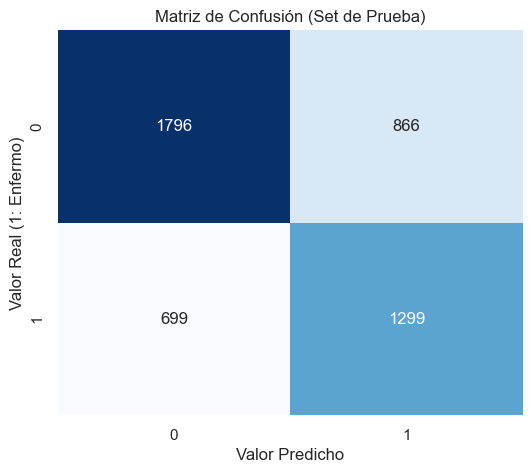

In [16]:
# Predicciones
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Métricas Generales
print("=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Matriz de Confusión Visual
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Set de Prueba)')
plt.ylabel('Valor Real (1: Enfermo)')
plt.xlabel('Valor Predicho')
plt.show()


=== Interpretación (Top Factores) ===
Un Odds Ratio > 1 indica aumento de riesgo de enfermedad crónica.
Un Odds Ratio < 1 indica factor 'protector' o menor riesgo.


,Variable,Coeficiente,Odds_Ratio
2,P301A_Básica especial,2.721518,15.203381
27,P203_Padres/Suegros,0.925336,2.522716
16,P209_Divorciado(a),0.791529,2.206767
20,P209_Viudo(a),0.554563,1.741180
30,P420A_En otro distrito,0.411013,1.508345
1,P207_Mujer,0.294927,1.343029
7,P301A_Primaria Incompleta,0.289830,1.336200
14,P301A_Superior Universitaria Incompleta,0.185550,1.203880
4,P301A_Maestria/Doctorado,0.122078,1.129842
23,P203_Jefe/Jefa,0.101783,1.107143


,Variable,Coeficiente,Odds_Ratio
9,P301A_Secundaria Incompleta,-0.416874,0.659104
24,P203_Nieto(a),-0.474812,0.622002
31,P420A_No acude a establecimiento de salud,-0.482123,0.617471
22,P203_Hijo(a)/Hijastro(a),-0.515611,0.597136
19,P209_Soltero(a),-0.532086,0.587378
15,P209_Conviviente,-0.644996,0.524665
5,P301A_No especificado,-0.823060,0.439086
29,P203_Yerno/Nuera,-0.873094,0.417657
28,P203_Trabajador Hogar,-1.278252,0.278524
17,P209_No especificado,-1.648943,0.192253


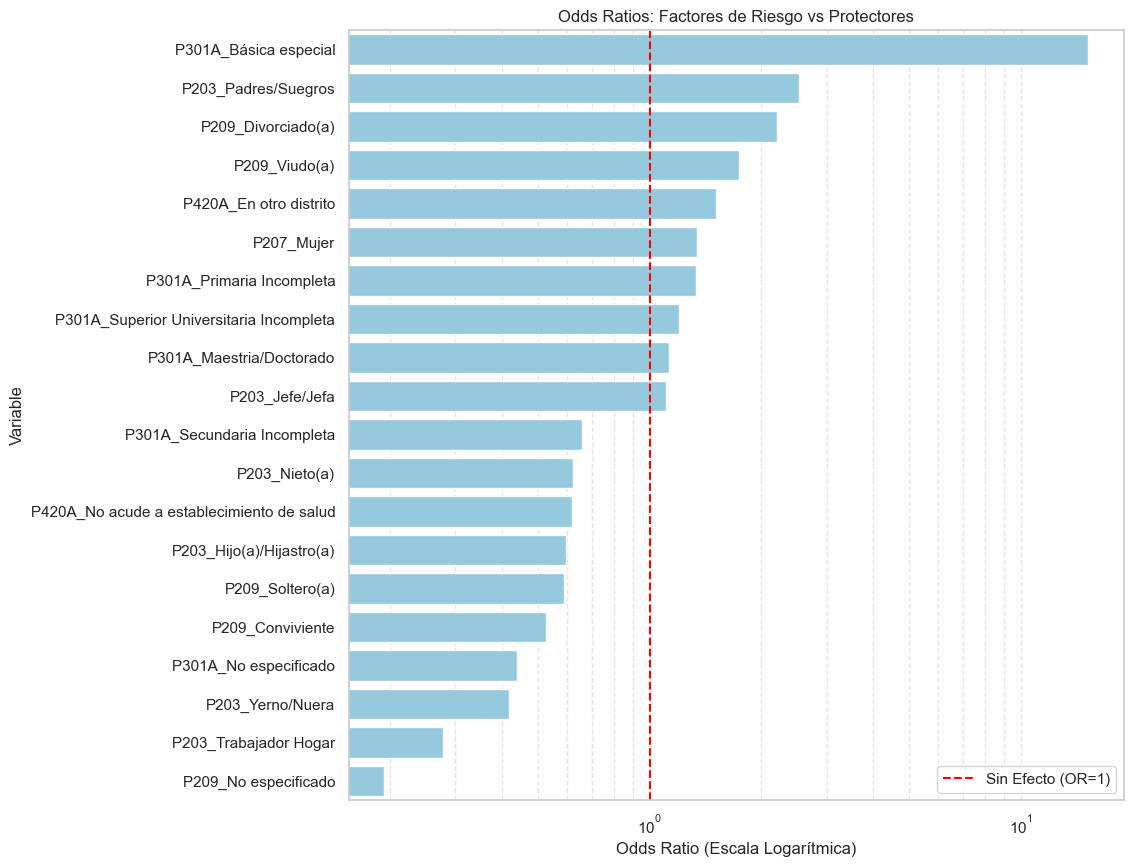

In [17]:
# Interpretación de Coeficientes (Odds Ratios)
coefs = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': log_reg.coef_[0],
    'Odds_Ratio': np.exp(log_reg.coef_[0])
})

# Ordenar por Odds Ratio
coefs = coefs.sort_values('Odds_Ratio', ascending=False)

print("\n=== Interpretación (Top Factores) ===")
print("Un Odds Ratio > 1 indica aumento de riesgo de enfermedad crónica.")
print("Un Odds Ratio < 1 indica factor 'protector' o menor riesgo.")
display(coefs.head(10)) # Top Riesgo
display(coefs.tail(10)) # Top Protectores

# Gráfico de los Odds Ratios más significativos (Top 20)
top_coefs = pd.concat([coefs.head(10), coefs.tail(10)])

plt.figure(figsize=(10, 10))
sns.barplot(data=top_coefs, y='Variable', x='Odds_Ratio', color='skyblue')
plt.axvline(x=1, color='red', linestyle='--', label='Sin Efecto (OR=1)')
plt.title('Odds Ratios: Factores de Riesgo vs Protectores')
plt.xlabel('Odds Ratio (Escala Logarítmica)')
plt.xscale('log') # Escala logarítmica para mejor visualización de OR
plt.legend()
plt.grid(True, axis='x', which='both', linestyle='--', alpha=0.5)
plt.show()